In [459]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [460]:
def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

In [332]:
# Activation Functions 
def sigmoid(input, derivative = False):
    if derivative:
        return input * (1 - input)
    
    return 1 / (1 + np.exp(-input))

def tanh(input, derivative = False):
    if derivative:
        return 1 - input ** 2
    
    return np.tanh(input)

def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))



In [1]:
# Long Short-Term Memory 
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        # Hyperparameters
        self.hidden_size = hidden_size

        # Forget Gate
        self.wf = initWeights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = initWeights(input_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))

        # Candidate Gate
        self.wc = initWeights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = initWeights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final Gate
        self.wy = initWeights(hidden_size, output_size)
        self.by = np.zeros((output_size, 1))

    # Reset Network Memory
    def reset(self):
        self.concat_inputs = {}

        self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1:np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    # Forward Propogation
    def forward(self, X_):
        outputs = []
        self.reset()
        for q in range(len(X_)):

            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], 
                                                    X_[q].reshape(-1,1)))
        
            self.forget_gates[q] = sigmoid(np.matmul(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.matmul(self.wi, self.concat_inputs[q]) + self.bi)
            self.candidate_gates[q] = tanh(np.matmul(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(np.matmul(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] 
            + self.input_gates[q] * self.candidate_gates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs += [np.matmul(self.wy, self.hidden_states[q]) + self.by]

        return np.array(outputs)
        
    # Backward Propogation
    def backward(self, errors, X, lr):
        d_wf, d_bf = 0, 0
        d_wi, d_bi = 0, 0
        d_wc, d_bc = 0, 0
        d_wo, d_bo = 0, 0
        d_wy, d_by = 0, 0


        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(X))):

            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.matmul(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.matmul(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.matmul(d_o, X[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.matmul(d_f, X[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.candidate_gates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.matmul(d_i, X[q].T)
            d_bi += d_i
            
            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q] * tanh(self.candidate_gates[q], derivative = True)
            d_wc += np.matmul(d_c, X[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.matmul(self.wf.T, d_f) + np.matmul(self.wi.T, d_i) 
            + np.matmul(self.wc.T, d_c) + np.matmul(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out = d_)

        self.wf += d_wf * lr
        self.bf += d_bf * lr

        self.wi += d_wi * lr
        self.bi += d_bi * lr

        self.wc += d_wc * lr
        self.bc += d_bc * lr

        self.wo += d_wo * lr
        self.bo += d_bo * lr

        self.wy += d_wy * lr
        self.by += d_by * lr

    # predict 
    def predict(self,X):
        out = []
        for i in range(len(X)):
            out.append(self.forward(X[i]))
        return np.array(out)

    # Train
    def train(self, X, y, epochs,lr):

        y_new = np.hstack((X,y))
        y_new = y_new[:,1:]
        
        for _ in range(epochs):
            for i in range(len(X)):
                prediction = self.forward(X[i])
                errors = []
                for q in range(len(prediction)):
                    errors += [y_new[i][q]- prediction[q]]
                errors = np.array(errors)
                self.backward(errors, self.concat_inputs,lr)
            current_loss = np.mean(abs(errors))
            print(current_loss)


In [550]:
# Checking on Sample Dataset
X = np.array([[[0],[1],[1],[1]],[[0],[0],[0],[0]]])
y = np.array([[[1]],[[0]]])
X= np.repeat(X, 100, axis=0)
y = np.repeat(y, 100, axis=0)
lstm = LSTM(3,2,1)

In [551]:
lstm.train(X,y,2000,0.1)

0.0018283146191412946
0.00547123604912876
0.009731915623812946
0.014370089309316603
0.01900156210188737
0.02321478426981465
0.026762649686794756
0.0295692507430627
0.03167152140477089
0.03315764792899432
0.03416008488799855
0.03480168181646528
0.03516839514047796
0.03545822829073977
0.03568839730914268
0.03581390304310089
0.035867781905808596
0.035874925796955955
0.03585338436822074
0.03581557289523177
0.03576939890119207
0.035719306008788865
0.03566721726845165
0.035613353913028556
0.03555691023601329
0.035496577047877065
0.035430919663458835
0.03535862748558462
0.03527865890390451
0.0351903072419736
0.035093211870883184
0.03498733481026292
0.0348729184939133
0.03475043585093457
0.03462053999012214
0.03448401778286593
0.03434174950321377
0.03419467527297204
0.03404376820531989
0.03389001367893983
0.033734393969760135
0.033577877415569654
0.033421411316847754
0.03326591783643859
0.03311229222041316
0.0329614027042026
0.03281409148155412
0.03267117609414999
0.032533450546068335
0.032401

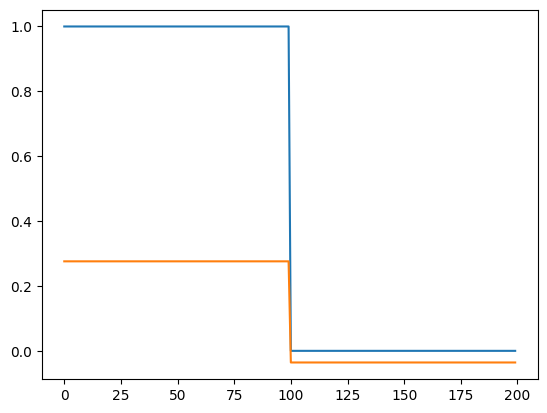

In [552]:
y_hat = lstm.predict(X)
y_hat_plot = y_hat.reshape(-1)
y_plot = y.reshape(-1)
sr = np.arange(len(y_plot))
plt.plot(sr, y_plot)
plt.plot(sr, y_hat_plot)

In [655]:
# Creating Dataset
df = pd.read_csv('Datasets/MSFT.csv')
df = df[['Date', 'Close']]

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  dates = []
  X, Y = [], []
  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return
    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]
    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, 
                                '2000-01-02', 
                                '2024-03-14', 
                                n=3)

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  Y = df_as_np[:, -1]
  Y = Y.reshape(-1,1,1)
  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

In [656]:
# Training the model
hidden_size = 25
lstm = LSTM(len(X[0][0])+hidden_size,hidden_size,1)
lstm.train(X,y,1000,0.01)

177.12432763272696
238.58391603049543
298.347092806259
283.76638086283896
265.944613577556
295.726189385458
295.7449521859951
295.76275882095894
298.73028327672574
280.8333284163073
298.78431073499524
298.7664341408327
298.78486212476565
298.8039817293813
298.8097342712912
298.81517403481865
298.820337354253
298.8254398474093
298.83026992956246
298.83483693303344


KeyboardInterrupt: 

In [657]:
# Predicting
y_hat = lstm.predict(X)

In [661]:
df = pd.read_csv('Datasets/MSFT.csv')
df = df[['Date', 'Close']]
# X = df.loc['2024-01-02':'2024-03-14']['Close'].to_numpy()
X = df['Close'].to_numpy()
X = X.reshape(1,len(X),1)
y = X[:,-1].reshape(-1,1,1)
X = X[:,:-1,:]

In [662]:
# Defining the model

hidden_size = 25
lstm = LSTM(len(X[0][0])+hidden_size,hidden_size,1)

In [667]:
# Training the model

lstm.train(X,y,1000,0.001)

24.314141467538747
24.067745137521783
23.831522728351718
23.619930547224985
23.47200865656804
23.437866684963197
23.4563932617152
23.43380352173945
23.44520331095317
23.424895079723186
23.438961501122414
23.419400554168238
23.439225488867784
23.412725934119916
23.421305872420287
23.40325522139793
23.41025297934407
23.399906223862377
23.409710956287277
23.39166554100077
23.40845810419312
23.385441643355644
23.405963252219614
23.37964106822839
23.403454193270164
23.374338554648187
23.400283960173624
23.369191547780908
23.396188274298677
23.364307263001322
23.39295770204907
23.35957219239129
23.38917648709851
23.35505301329667
23.385149045421336
23.35049059123098
23.382180910524493
23.345856803330424
23.378430527052274
23.344073354337997
23.344890199943134
23.334212574723956
23.341108617968537
23.32985821541989
23.37973372685272
23.334155121101762
23.334296462252226
23.428943350738425
23.329226170278925
23.42392544683415
23.325036715023717
23.417857158612485
23.322454032143213
23.40645435

KeyboardInterrupt: 

In [698]:
# Predicting
sample_size = 100
start = 5000
X_test = X[:,start:start+sample_size,:]
y_hat = lstm.predict(X_test)

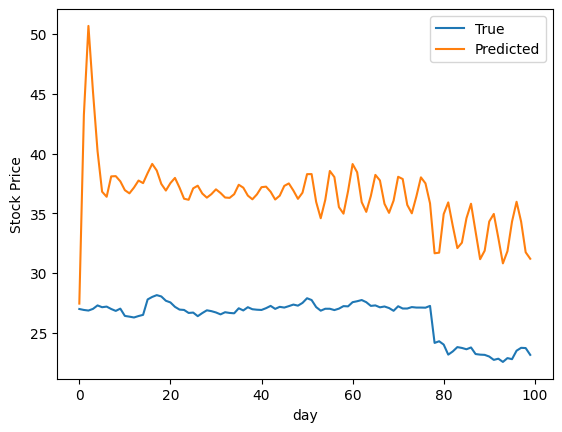

In [699]:
# Plotting

sr = np.arange(len(X_test[0][:]))
plt.plot(sr, X_test[0][:], label = "True")
plt.plot(sr, y_hat[0][:,0,0], label ='Predicted')
plt.xlabel("day")
plt.ylabel("Stock Price")
plt.legend()